In [1]:
# Import Libraries
import sys
from pathlib import Path
import numpy as np 
import pickle

# Import Code
sys.path.append(str(Path.cwd().parent))
sys.argv = ["notebook", "--config", "../config/mros_ses02_config.yaml"] 
from src.config.read_config import read_config
from src.pipeline_io.get_mastersheet import get_mastersheet
from src.pipeline_io.read_annot import read_annot
from src.analysis.process_sleep_stages import process_sleep_stages
from src.analysis.process_signals import process_signals
from src.analysis.selecting_windows import selecting_windows

# Run first part of the code 
config = read_config()
mastersheet = get_mastersheet(config)
row = mastersheet.iloc[0]
print(row["subject_id"])

# Read annotation XML file
full_sleep_stages, df_events, epoch_length_sec = read_annot(
    annot_path = row["annot_path"],
    duration_sec = row["duration_sec"],
    dataset_name = config.dataset.name)

# Get sleep stages only for the night part
sleep_stages, sleep_onset_time = process_sleep_stages(
    full_sleep_stages, 
    epoch_length_sec,     
    start_time = row["start_time"])

processed_signals = process_signals(
    config, 
    row, 
    full_sleep_stages, 
    epoch_length_sec)

windows_dict = selecting_windows(
            config,
            epoch_length_sec, 
            sleep_stages, 
            sleep_onset_time,
            processed_signals)

/Users/alicealbrecht/Desktop/UCSF/pipeline_project/datasets/mastersheets/mros_ses02_mastersheet.csv
✅ Loading existing mastersheet from /Users/alicealbrecht/Desktop/UCSF/pipeline_project/datasets/mastersheets/mros_ses02_mastersheet.csv
bi0010
Clean R-peaks: 98.5%
[INFO]: Processing Signal: ecg
[INFO]: Processing Signal: emg_chin


KeyError: 'signals/EMG/EMG_LegL not found in file /Users/alicealbrecht/Desktop/UCSF/pipeline_project/datasets/hdf5/mros/ses02/MrOS_ses02_bi0010_signals.h5'

In [ ]:
window_dict

NameError: name 'window_dict' is not defined

✅ Loaded EMG chin signal: 8532480 samples
🕒 Duration: 555.50 minutes (9.26 hours)
🔄 Sampling frequency: 256 Hz


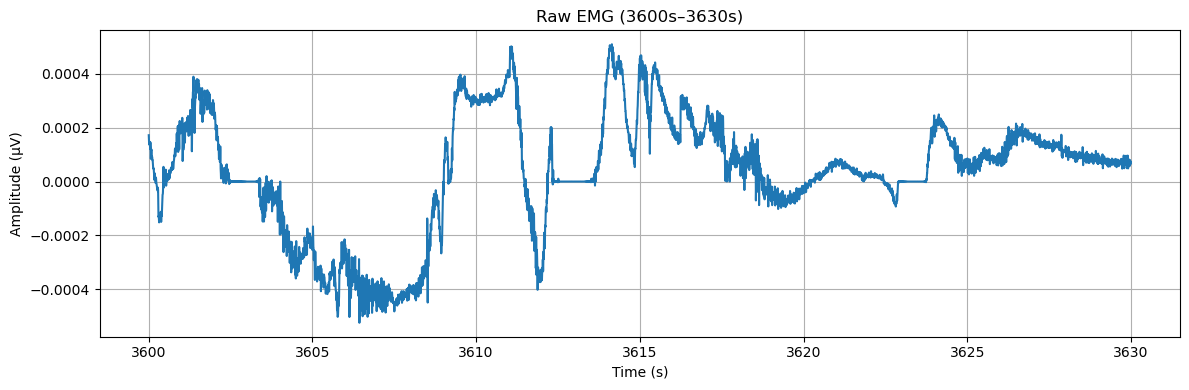


📊 Raw EMG Stats:
  - Length: 8532480 samples
  - Min:    -0.001
  - Max:    0.001
  - Mean:   -0.000
  - Std:    0.000
  - RMS:    0.000
  - Peak-to-peak: 0.001

📊 Bandpass Filtered EMG Stats:
  - Length: 8532480 samples
  - Min:    -0.001
  - Max:    0.000
  - Mean:   -0.000
  - Std:    0.000
  - RMS:    0.000
  - Peak-to-peak: 0.001


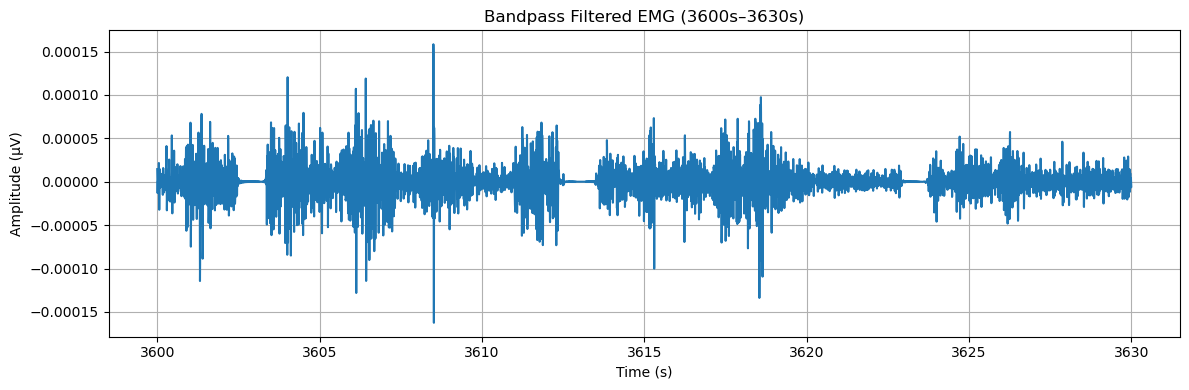


📊 Rectified EMG Stats:
  - Length: 8532480 samples
  - Min:    0.000
  - Max:    0.001
  - Mean:   0.000
  - Std:    0.000
  - RMS:    0.000
  - Peak-to-peak: 0.001


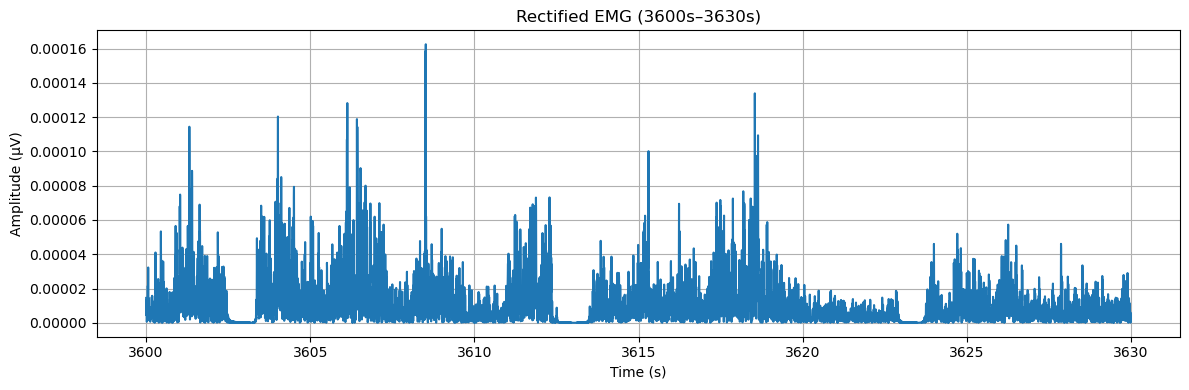


📊 Notch Filtered EMG Stats:
  - Length: 8532480 samples
  - Min:    -0.001
  - Max:    0.001
  - Mean:   -0.000
  - Std:    0.000
  - RMS:    0.000
  - Peak-to-peak: 0.001


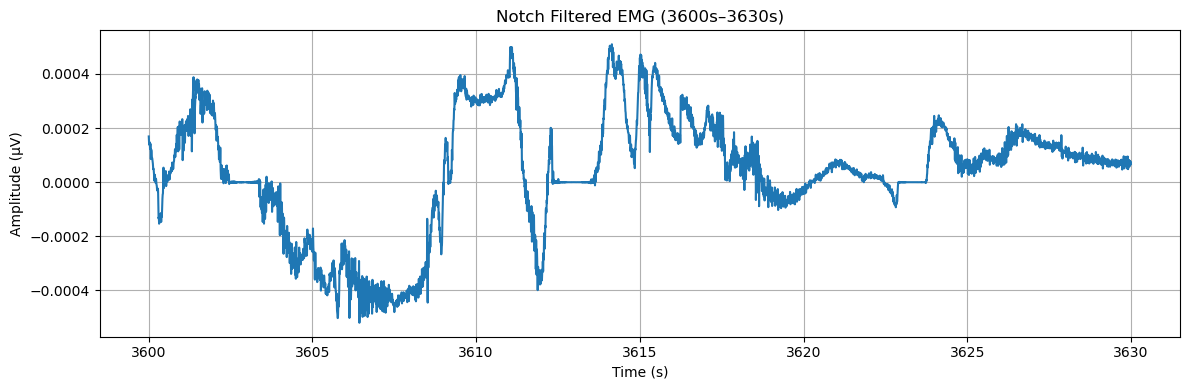


📊 Smoothed Envelope Stats:
  - Length: 8532480 samples
  - Min:    0.000
  - Max:    0.000
  - Mean:   0.000
  - Std:    0.000
  - RMS:    0.000
  - Peak-to-peak: 0.000


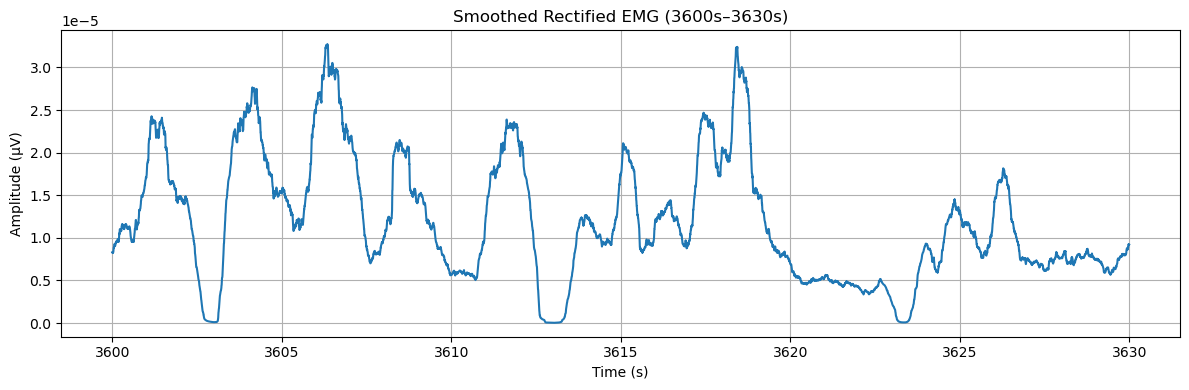


✅ Preprocessing pipeline complete.


In [28]:
# 1. Imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
import mne  # Optional
import seaborn as sns

duration_sec = len(emg_chin) / sfreq_emg

print(f"✅ Loaded EMG chin signal: {len(emg_chin)} samples")
print(f"🕒 Duration: {duration_sec / 60:.2f} minutes ({duration_sec / 3600:.2f} hours)")
print(f"🔄 Sampling frequency: {sfreq_emg} Hz")

# 3. Utility function to print summary stats
def print_signal_stats(signal, label):
    print(f"\n📊 {label} Stats:")
    print(f"  - Length: {len(signal)} samples")
    print(f"  - Min:    {np.min(signal):.3f}")
    print(f"  - Max:    {np.max(signal):.3f}")
    print(f"  - Mean:   {np.mean(signal):.3f}")
    print(f"  - Std:    {np.std(signal):.3f}")
    print(f"  - RMS:    {np.sqrt(np.mean(signal**2)):.3f}")
    print(f"  - Peak-to-peak: {np.ptp(signal):.3f}")

# 4. Plot a window of signal
def plot_emg_window(signal, sfreq, start_sec=0, duration_sec=30, title="EMG"):
    start_idx = int(start_sec * sfreq)
    end_idx = int((start_sec + duration_sec) * sfreq)
    time_axis = np.arange(start_idx, end_idx) / sfreq
    plt.figure(figsize=(12, 4))
    plt.plot(time_axis, signal[start_idx:end_idx])
    plt.title(f"{title} ({start_sec}s–{start_sec+duration_sec}s)")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude (µV)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Preview raw signal
plot_emg_window(emg_chin, sfreq_emg, start_sec=3600, duration_sec=30, title="Raw EMG")
print_signal_stats(emg_chin, "Raw EMG")

# 5. Preprocessing functions
def bandpass_filter(signal, sfreq, l_freq=10, h_freq=100, order=4):
    nyq = 0.5 * sfreq
    low = l_freq / nyq
    high = h_freq / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)

def notch_filter(signal, sfreq, freq=60.0, quality=30):
    from scipy.signal import iirnotch
    b, a = iirnotch(freq / (sfreq / 2), quality)
    return filtfilt(b, a, signal)

def rectify(signal):
    return np.abs(signal)

# 6. Apply preprocessing
emg_bandpassed = bandpass_filter(emg_chin, sfreq_emg, l_freq=10, h_freq=100)
print_signal_stats(emg_bandpassed, "Bandpass Filtered EMG")
plot_emg_window(emg_bandpassed, sfreq_emg, start_sec=3600, duration_sec=30, title="Bandpass Filtered EMG")

emg_rectified = rectify(emg_bandpassed)
print_signal_stats(emg_rectified, "Rectified EMG")
plot_emg_window(emg_rectified, sfreq_emg, start_sec=3600, duration_sec=30, title="Rectified EMG")

# Optional: Notch filter
emg_notched = notch_filter(emg_chin, sfreq_emg)
print_signal_stats(emg_notched, "Notch Filtered EMG")
plot_emg_window(emg_notched, sfreq_emg, start_sec=3600, duration_sec=30, title="Notch Filtered EMG")

# Optional: Envelope / smoothing
def moving_average(signal, window_sec, sfreq):
    window_samples = int(window_sec * sfreq)
    return np.convolve(signal, np.ones(window_samples)/window_samples, mode='same')

emg_smoothed = moving_average(emg_rectified, window_sec=0.5, sfreq=sfreq_emg)
print_signal_stats(emg_smoothed, "Smoothed Envelope")
plot_emg_window(emg_smoothed, sfreq_emg, start_sec=3600, duration_sec=30, title="Smoothed Rectified EMG")

# 7. Summary
print("\n✅ Preprocessing pipeline complete.")